In [180]:
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import interpolate, signal

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]

## 4.2 Explore the Data in ITK-SNAP (5 points)

- [ ] insert screenshots

## 4.3 Loading and Displaying 3D Images with Python (10 points)

### 4.3.1 Reading and Writing Images

In [64]:
def my_read_nifti(filename):
    """Read NIfTI image voxels and header

    :param filename: path to image to read
    :return: tuple (img, hdr) consisting of numpy voxel array and nibabel NIfTI header
    """    
    img = nib.load(filename)
    
    return img.get_fdata(), img.header

In [65]:
def my_write_nifti(filename, img, header=None):
    """Write NIfTI image voxels and header

    :param filename: path to the image to save
    :param img: numpy voxel array
    :param header: nibabel NIfTI header, defaults to None
    """
    if header is not None:
        nifti_img = nib.Nifti1Image(img, affine=header.get_best_affine(), header=header)
    else:
        nifti_img = nib.Nifti1Image(img, affine=np.ones((len(img.shape), 1)))
        
    nib.save(nifti_img, filename)

### 4.3.2 Viewing Images
- [ ] comment code
- [ ] include title for plot and colorbar
- [ ] logic behind the aspect ratio scaling?

In [214]:

def my_view(img, xhair=None, header=None, crange=None, cmap='gray'):
    """Display a 3D image in a layout similar to ITK-SNAP

    :param img: 3D voxel array
    :param xhair: crosshair position
    :param header: image header (returned by my_read_nifti), defaults to None
    :param crange: intensity range tuple with min and max values, defaults to None
    :param cmap: colormap (see matplotlib docs), defaults to 'gray'
    """
    vmin = None
    vmax = None
    
    if crange is not None:
        vmin = crange[0]
        vmax = crange[1]

    if xhair is None:
        xhair = (int(img.shape[0]/2), int(img.shape[1]/2), int(img.shape[2]/2))
            
    fig, ax = plt.subplots(2, 2)

    im1 = ax[0, 0].imshow(img[:, :, xhair[2]], cmap=cmap, vmin=vmin, vmax=vmax)

    ax[0, 0].imshow(img[:, :, xhair[2]].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0, 0].invert_xaxis()
    ax[0, 0].invert_yaxis()
    ax[0, 0].axvline(xhair[0])
    ax[0, 0].axhline(xhair[1])
    
    ax[0, 1].imshow(img[xhair[0], :, :].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0, 1].invert_xaxis()
    ax[0, 1].invert_yaxis()
    ax[0, 1].axvline(xhair[1])
    ax[0, 1].axhline(xhair[2])
    
    ax[1, 0].axis('off')
    cax = plt.axes([0.175, 0.15, 0.3, 0.05])
    plt.colorbar(im1, orientation='horizontal', ax=ax[0,0], cax=cax)

    ax[1, 1].imshow(img[:, xhair[1], :].transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1, 1].invert_xaxis()
    ax[1, 1].invert_yaxis()
    ax[1, 1].axvline(xhair[2])
    ax[1, 1].axhline(xhair[0])
    
    if header is not None:
        # is this correct? if yes why?
        ax[0, 0].set_aspect(1/header['pixdim'][1])
        ax[0, 1].set_aspect(1/header['pixdim'][2])
        ax[1, 1].set_aspect(1/header['pixdim'][1])

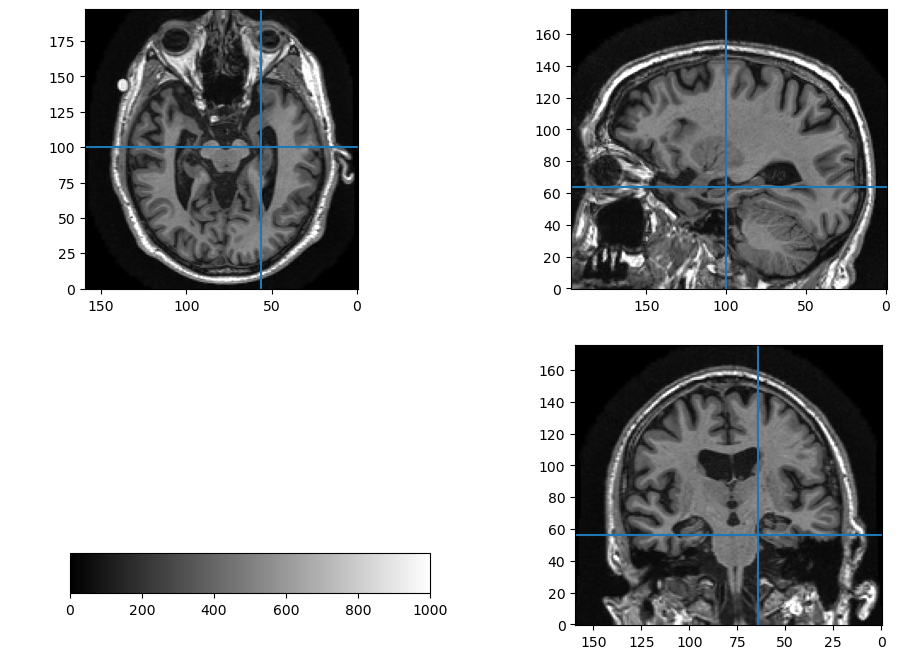

In [68]:
img, hdr = my_read_nifti("data/baseline.nii")
my_view(img, xhair=(56,100,64), header=hdr, crange=(0, 1000))

## 5.1 Apply Affine Transformations to 3D Images (10 points)

In [169]:
def my_read_trasnform(filename):
    """Read 3D transform (4x4 matrix) from file

    :param filename: file containing transform matrix
    :return: tuple (A, b) where A is 3x3 affine matrix, b is translation vector
    """
    Ab = np.loadtxt(filename)
    
    A = Ab[:3, :3]
    b = np.expand_dims(Ab[:3, 3], axis=1) # dimension (3, 1) instead of (3,)
    
    return A, b 

In [170]:
def my_transform_image(I_ref, I_mov, A, b, method='linear', fill_value=0):
    """Transform a moving image into the space of the fixed field

    :param I_ref: 3D voxel array of the fixed (reference) image
    :param I_mov: 3D voxel array of the moving image
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param method: interpolation method, defaults to 'linear'
    :param fill_value: value with which to replace missing values, defaults to 0
    :return: 3D voxel array of the affine-transformed moving image
    """
    nx, ny, nz = I_ref.shape
    x = np.linspace(0, nx-1, nx)
    y = np.linspace(0, ny-1, ny)
    z = np.linspace(0, nz-1, nz)

    xp, yp, zp = np.meshgrid(x, y, z, indexing='ij')
    Xp = np.stack((xp, yp, zp))
    
    # using the poperty for transpose of sot product of matrices 
    # (MN)^T = (N^T)(M^T) 
    TXp = np.dot(np.transpose(Xp), np.transpose(A)) + np.transpose(b)
    
    I_res = interpolate.interpn((x, y, z), I_mov, TXp, method=method, 
                                     bounds_error=False, fill_value=fill_value)
    I_res = np.transpose(I_res)

    return I_res    

In [171]:
I_ref, hdr_ref = my_read_nifti("data/baseline.nii")
I_mov, hdr_mov = my_read_nifti("data/followup.nii")

A, b = my_read_trasnform("data/f2b.txt")

I_res = my_transform_image(I_ref, I_mov, A, b)

### Resampled image

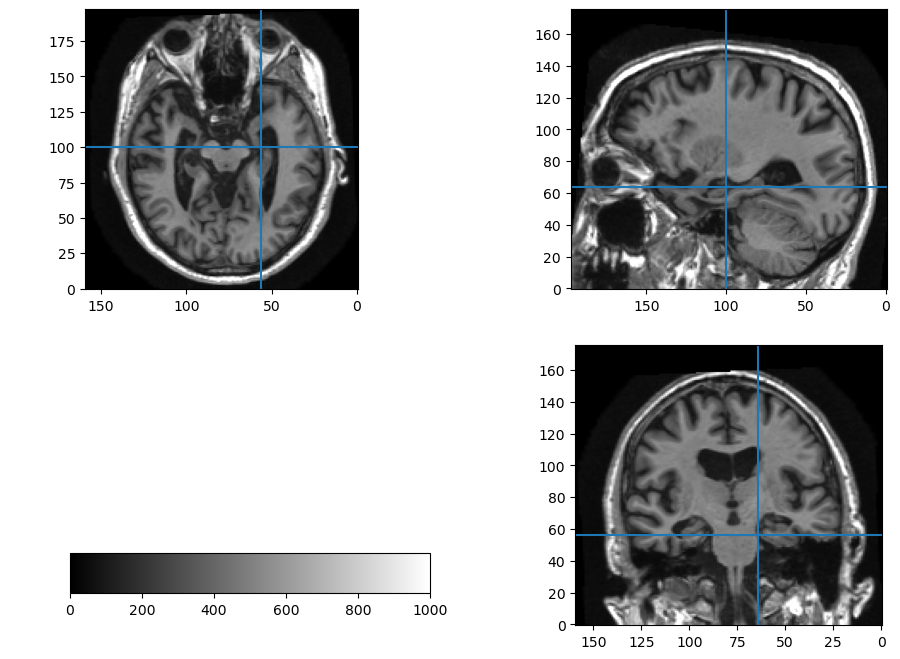

In [172]:
my_view(I_res, xhair=(56,100,64), header=hdr_mov, crange=(0, 1000))

### Baseline image

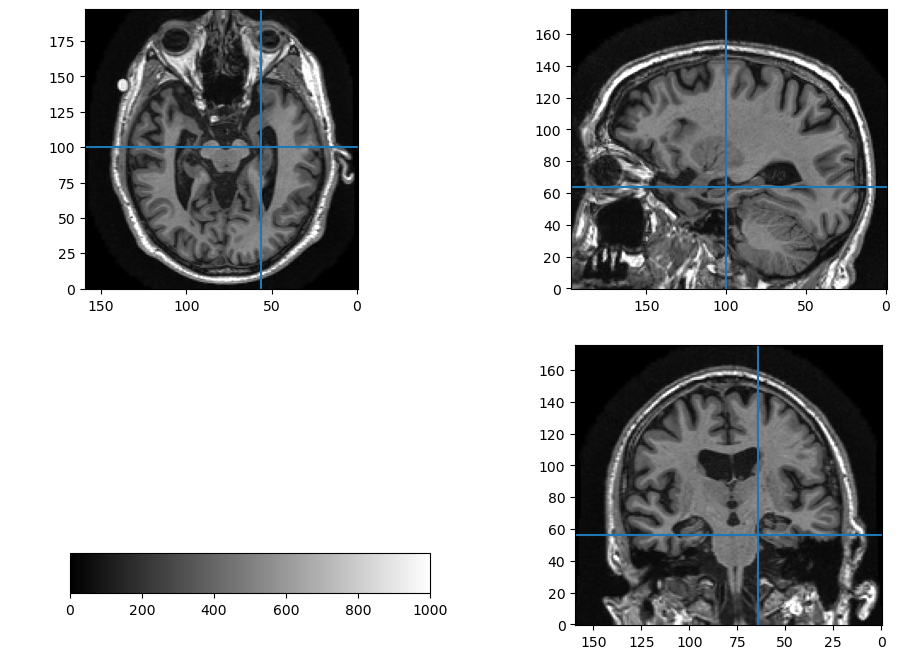

In [173]:
my_view(I_ref, xhair=(56,100,64), header=hdr_ref, crange=(0, 1000))

## 5.2 Effects of Low Pass Filtering on Difference Image Computation (15 points)

### 5.2.1 Implement Gaussian Low-Pass Filtering for 3D Volumes

In [233]:
def my_gaussian_lpf(image, sigma):
    """Apply 3D Gaussian low-pass filtering to an image

    :param image: 3D voxel array om the input image
    :param sigma: std dev of the Gaussian kernel in voxel units
    :return: 3D voxel array of the filtered image
    """
    halfsize = int(np.ceil(3.5 * sigma))
    x = np.linspace(-halfsize, halfsize, 2*halfsize+1)
    
    G = np.exp(-np.power(x/sigma, 2) / 2)/(sigma * np.sqrt(2*math.pi))
    
    Gz = np.expand_dims(G, axis=(1, 0)) # (1, 1, size)
    Gy = np.expand_dims(G, axis=(2, 0)) # (1, size, 1)
    Gx = np.expand_dims(np.expand_dims(G, axis=1), axis=1) # (size, 1, 1)

    G = Gx * Gy * Gz
    
    lpf_img = signal.fftconvolve(image, G, mode='same')
    
    return lpf_img

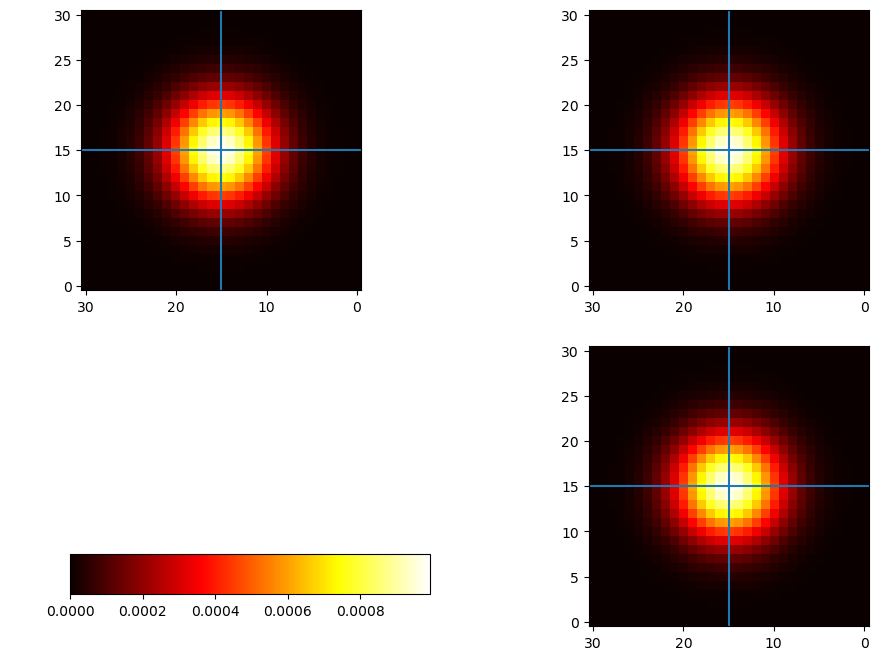

In [234]:
delta = np.zeros(shape=(31, 31, 31))
delta[15, 15, 15] = 1
lpf_delta = my_gaussian_lpf(delta, sigma=4)

my_view(lpf_delta, cmap='hot')

### 5.2.2 Implement Mean Filtering

In [236]:
def my_mean_lpf(image, radius):
    """Apply 3D mean filtering to an image

    :param image: 3D voxel numpy array
    :param radius: size of the mean filter
    :return: mean filtered image
    """    
    size = int(2*radius + 1)
    mean_lpf = np.ones(shape=(size, size, size))/size**3
    
    mean_lpf_image = signal.fftconvolve(image, mean_lpf, mode='same')
    
    return mean_lpf_image

### Baseline Image Filtered with Gaussian Filter at $\sigma$ = 2

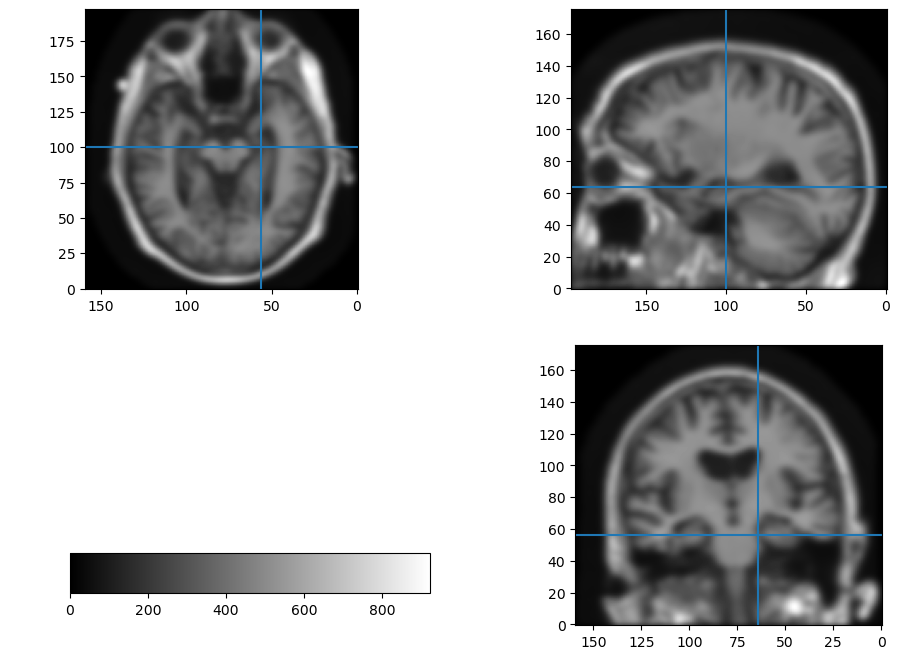

In [238]:
I_ref_gaussian_lpf = my_gaussian_lpf(I_ref, sigma=2)

my_view(I_ref_gaussian_lpf, xhair=(56,100,64), header=hdr_ref)

### Baseline Image filtered with Mean Filter radius=2

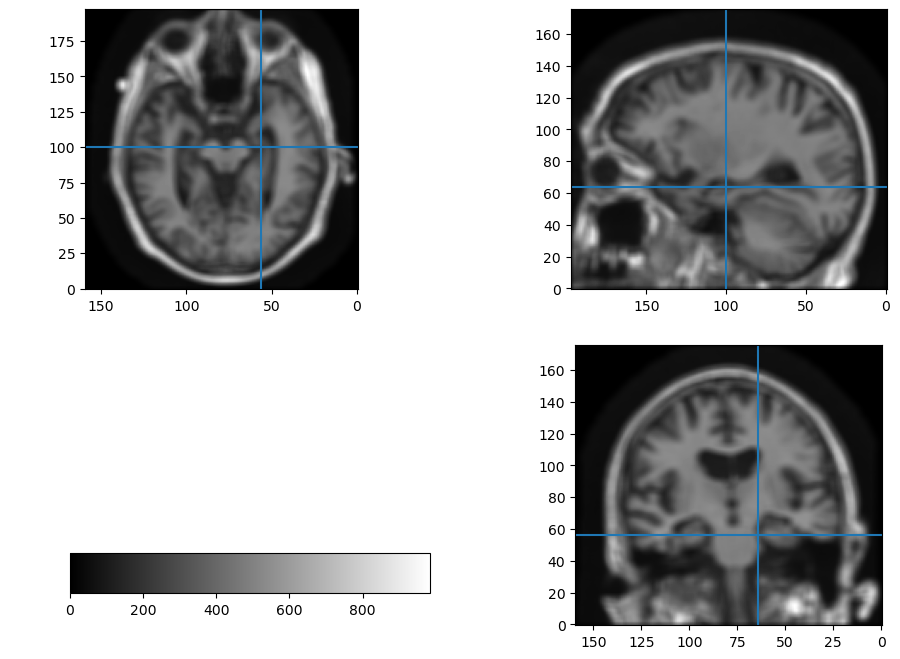

In [239]:
I_ref_mean_lpf = my_mean_lpf(I_ref, radius=2)

my_view(I_ref_mean_lpf, xhair=(56,100,64), header=hdr_ref)

### 5.2.3 Compute and Show Difference Images

#### $K_B$ = None, $K_F$ = None, Interpolation = Nearest Neighbor

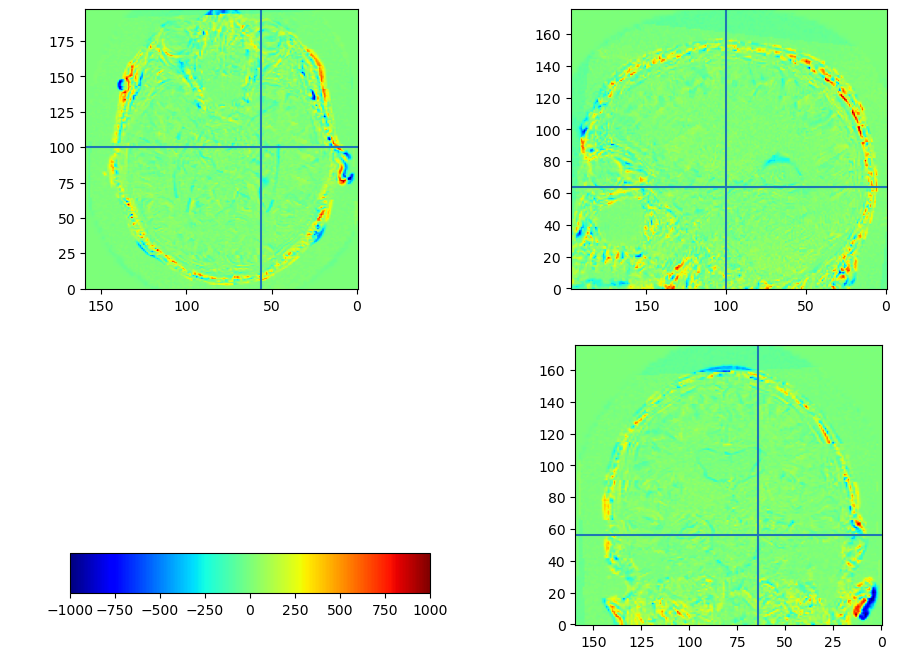

In [243]:
diff1 = my_transform_image(I_ref, I_mov, A, b, method='nearest') - I_ref

my_view(diff1, xhair=(56, 100, 64), header=hdr_ref, crange=(-1000, 1000), cmap='jet')

#### $K_B$ = None, $K_F$ = None, Interpolation = Linear

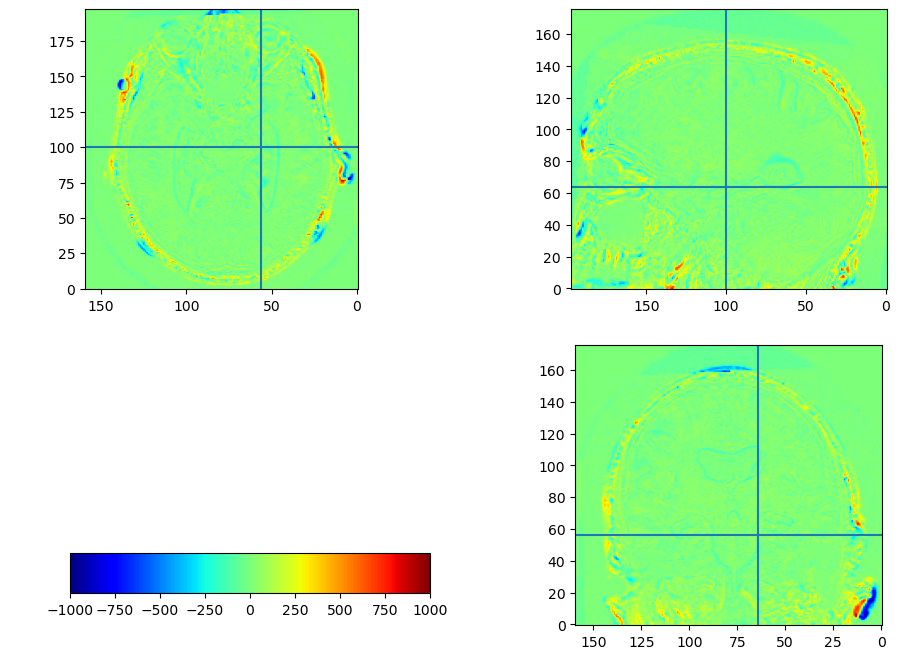

In [244]:
diff2 = my_transform_image(I_ref, I_mov, A, b, method='linear') - I_ref

my_view(diff2, xhair=(56, 100, 64), header=hdr_ref, crange=(-1000, 1000), cmap='jet')

#### $K_B$ = Gaussian $\sigma$=2, $K_F$ = Gaussian $\sigma$=2, Interpolation = Linear

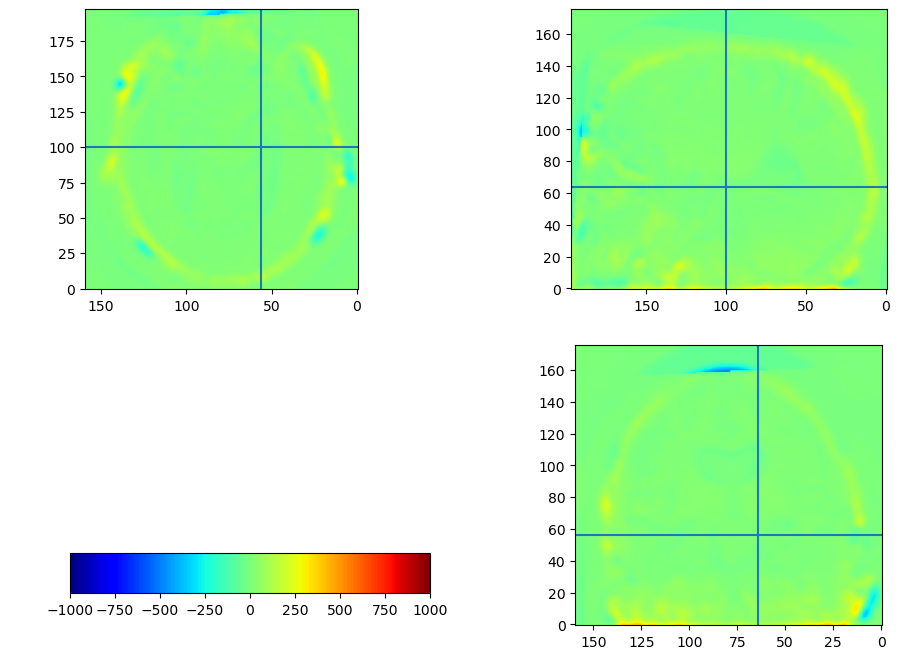

In [245]:
I_ref_lpf = my_gaussian_lpf(I_ref, sigma=2)
I_mov_lpf = my_gaussian_lpf(I_mov, sigma=2)

diff3 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff3, xhair=(56, 100, 64), header=hdr_ref, crange=(-1000, 1000), cmap='jet')

#### $K_B$ = Mean radius=2, $K_F$ = Mean radius=2, Interpolation = Linear

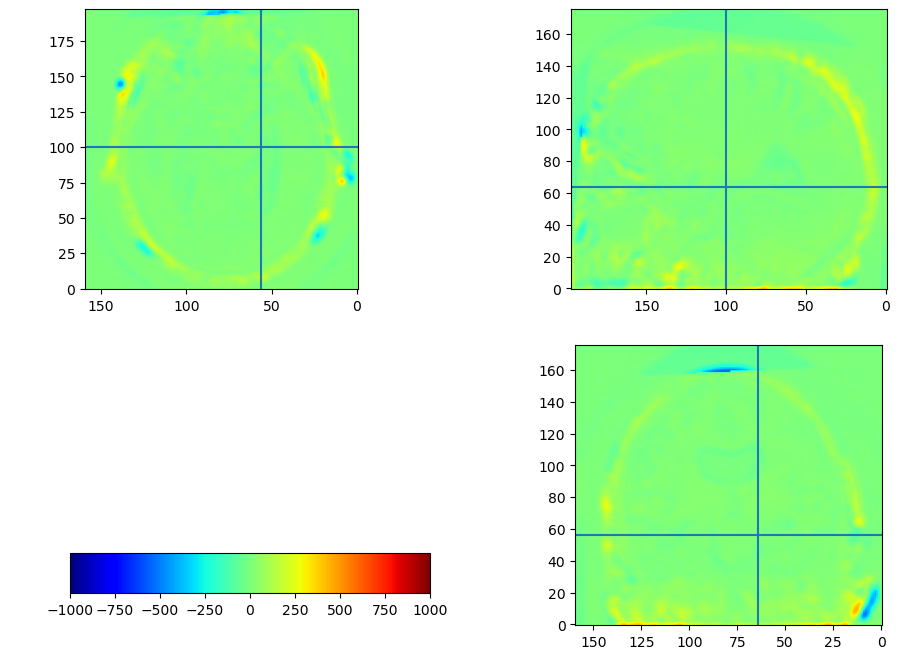

In [246]:
I_ref_lpf = my_mean_lpf(I_ref, radius=2)
I_mov_lpf = my_mean_lpf(I_mov, radius=2)

diff4 = my_transform_image(I_ref_lpf, I_mov_lpf, A, b, method='linear') - I_ref_lpf

my_view(diff4, xhair=(56, 100, 64), header=hdr_ref, crange=(-1000, 1000), cmap='jet')

## 5.3 Quantify Intensity Difference over Regions of Interest (10 points)

In [ ]:
def my_rms_over_roi(image, seg, label):
    """Compute RMS of a difference image over a label in the segmentation

    :param image: 3D voxel array
    :param seg: 3D voxel array with segmentation 
    :param label: 
    """    